<a href="https://colab.research.google.com/github/aleks-haksly/portfolio/blob/main/SQL/optimization/ClickHouse_table_size_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическая работа по оптимизации занимаемого на диске места таблицы ClickHouse

### Настраиваем подключение

In [2]:
# Установим нужные библиотеки
!pip install clickhouse_driver --quiet
!pip install itables --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.9/935.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.0 MB/s eta 0:00:00


In [3]:
# Импортируем используемые в работе модули
import pandas as pd
from clickhouse_driver import Client
import plotly.express as px
import numpy as np
import ipywidgets as widgets
from itables import show
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

In [4]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')
host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение
database_rw='hardda_student_data' # БД с правами чтение и запись
source_table = "live_adverts_dwh" # Таблица до оптимизации
optimized_table = "dp_live_adverts_alekse_fomin" # Таблица после оптимизации

In [5]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

### Посмотрим на оптимизируемую таблицу и соберем о ней предварительную информацию

In [10]:
# Смотрим на таблицу
sql = f"""
SELECT
  *
FROM
  {source_table}
LIMIT 5
"""
result, columns = client_r.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
df.head(5)

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,userType
0,2022-02-01,130486371,2012-11-06 07:12:00,0,Москва,123578197,unknown,Unknown,Unknown model,123599132,0,0
1,2022-02-01,129236743,2012-11-06 07:31:13,0,Москва,123477706,unknown,Unknown,Unknown model,123493336,0,0
2,2022-02-01,130358537,2012-11-06 07:35:24,0,Москва,123799514,unknown,Unknown,Unknown model,123820472,0,0
3,2022-02-01,129230893,2012-11-06 08:01:17,0,Москва,123730252,unknown,Unknown,Unknown model,123751205,0,0
4,2022-02-01,169982253,2012-11-06 08:24:59,0,Москва,123653651,unknown,Unknown,Unknown model,123674596,0,0


In [12]:
# Информация о колонках оптимизируемой таблицы из системных таблиц: из таблицы system.columns
sql = f"""
SELECT
  name as column_name,
  type as dtype
FROM
  system.columns
where table = '{source_table}'
"""
result, columns = client_r.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
source_table_info1 = df.set_index('column_name')
source_table_info1

,dtype
column_name,
execution_date,Date
advert_id,String
created_at,DateTime
price,UInt64
region,String
user_id,String
platform,String
auto_brand,String
auto_model,String


In [13]:
# Информация об оптимизируемой таблице вцелом: из системной таблицы system.tables
sql = f"""
SELECT
  name as table_name,
  engine,
  partition_key,
  sorting_key,
  primary_key,
  total_rows,
  formatReadableSize(total_bytes) as total_size
from
  system.tables
where
  name = '{source_table}'
"""
result, columns = client_r.execute(sql, with_column_types=True)
source_table_info2 = pd.DataFrame(result, columns=[tuple[0] for tuple in columns]).set_index('table_name')
source_table_info2

,engine,partition_key,sorting_key,primary_key,total_rows,total_size
table_name,,,,,,
live_adverts_dwh,MergeTree,,execution_date,execution_date,93120947,3.36 GiB


Вдими, что текущий размер таблицы на диске составляет 3.36 GiB

In [16]:
# Сохраним список колонок и количество строк оптимизируемой таблицы
all_columns = source_table_info1.index.to_list()
total_rows = source_table_info2['total_rows'].iloc[0]

### Посчитаем другую полезную информацию для дальнейшей оптимизации

In [22]:
# Посчитаем количество уникальных значений в каждой колонке
sql = f"SELECT %s FROM {source_table}" % ", ".join([f'uniq({col}) as {col}' for col in all_columns])
result, columns = client_r.execute(sql, with_column_types=True)
uniq_values = pd.DataFrame(result, columns=[tuple[0] for tuple in columns]).transpose().rename(columns={0: "uniq_values_count"})
uniq_values.index.name = 'column_name'
uniq_values['uniq_ratio_%'] = uniq_values['uniq_values_count'].apply(lambda x: str(round(x * 100 / total_rows, 1)) + ' %')

In [23]:
# Посчитаем минимальные и максимальные значения в каждой колонке
sql = f"SELECT %s FROM {source_table}" % ", ".join([f"concat(toString(min({col})), ' - ' , toString(max({col}))) as {col}" for col in all_columns])
result, columns = client_r.execute(sql, with_column_types=True)
min_max_values = pd.DataFrame(result, columns=[tuple[0] for tuple in columns]).transpose().rename(columns={0: "min-max_values"})

### Визуализируем собранную информацию

In [24]:
# Посмотрим на собранную информацию по каждой колонке
source_table_info1 = source_table_info1.join(uniq_values).join(min_max_values)
source_table_info1

,dtype,uniq_values_count,uniq_ratio_%,min-max_values
column_name,,,,
execution_date,Date,365,0.0 %,2022-02-01 - 2023-01-31
advert_id,String,8972127,9.6 %,123458274 - 271644234
created_at,DateTime,7672977,8.2 %,2012-11-06 06:50:33 - 2023-01-31 17:57:37
price,UInt64,81062,0.1 %,0 - 154014141415
region,String,21,0.0 %,Волгоград - Челябинск
user_id,String,1409126,1.5 %,123456782 - 152308061
platform,String,5,0.0 %,android - unknown
auto_brand,String,169,0.0 %,Acura - УАЗ
auto_model,String,2363,0.0 %,UNI-V - Фермер


### Напишем несколько функций для автоматизации подбора оптимального типа данных для полей таблицы

In [25]:
# Функция для подбора минимально достаточного UInt типа данных для хранения любого числа в колонке
def uint_optimize(n: int) -> str:
    """Returns smallest UInt dtype that can be used to store passed UInt value"""
    uint_types_dict = {"UInt8" : 255,
                       'UInt16': 65535,
                       "UInt32": 4294967295,
                       "UInt64": 18446744073709551615,
                       "UInt128": 340282366920938463463374607431768211455,
                       "UInt256": 115792089237316195423570985008687907853269984665640564039457584007913129639935}
    for k in  sorted(uint_types_dict, key = uint_types_dict.get):
        if n <= uint_types_dict[k]:
            return k
    return None

In [27]:
# Функция возваращает максимально большое целое число из значений в колонке,
# Если все значения в колонке могут быть приведены к целым положительным числам, иначе возвращает None
def get_uint_max_value(column_name: str, connection = client_r, table: str = source_table) -> int or None:
    """Returns column max UInt value for colomns defined as String type. If column data contains not UInt type returns None"""
    sql = f'''
    SELECT
        toUInt256OrNull({column_name}) as max_value
    FROM {table}
    order by max_value DESC NULLS FIRST
    LIMIT 1
    '''
    return client_r.execute(sql)[0][0]

In [28]:
# Функция возвращает предполагаемый оптимальный тип даынных для колонки
def optimize(column_name: str, dtype: str, min_max_values: str, uniq_count: str) -> str:
    """Returns recommended dtype for column optimization if found. Otherwise returns '~' + original dtype"""
    if 'UInt' in dtype:
        return uint_optimize(int(min_max_values.split(' - ')[1]))
    if 'String' in dtype:
        if max_value := get_uint_max_value(column_name):
            return uint_optimize(max_value)
        else:
            if uniq_count < 10:
                return 'Enum8'
            elif uniq_count < 10_000:
                return 'LowCardinality'
    return '~' + dtype

### Рассчитаем и добавим в таблицу столбец optimized_dt с рекомендуемыми типами данных

In [29]:
source_table_info1['optimized_dtype'] = np.vectorize(optimize)(
    source_table_info1.index,
    source_table_info1['dtype'],
    source_table_info1['min-max_values'],
    source_table_info1['uniq_values_count'])

In [30]:
source_table_info1

,dtype,uniq_values_count,uniq_ratio_%,min-max_values,optimized_dtype
column_name,,,,,
execution_date,Date,365,0.0 %,2022-02-01 - 2023-01-31,~Date
advert_id,String,8972127,9.6 %,123458274 - 271644234,UInt32
created_at,DateTime,7672977,8.2 %,2012-11-06 06:50:33 - 2023-01-31 17:57:37,~DateTime
price,UInt64,81062,0.1 %,0 - 154014141415,UInt64
region,String,21,0.0 %,Волгоград - Челябинск,LowCardinality
user_id,String,1409126,1.5 %,123456782 - 152308061,UInt32
platform,String,5,0.0 %,android - unknown,Enum8
auto_brand,String,169,0.0 %,Acura - УАЗ,LowCardinality
auto_model,String,2363,0.0 %,UNI-V - Фермер,LowCardinality


### Анализ собранных данных

1. поле **execution_date** имеет тип данных *Date* и представляет собой последовательность дать с 2022-02-01 по 2023-01-31, содержит 365 уникальных значений, так как в таблице представлены данные за промежуток времени, равный 1 году. Сжатие данного поля не представляет особого интреса, так как данные занимаюи всего 814 KiB

2. поле **advert_id** имеет тип данных *String*, при этом все данные внутри поля представляют собой целые числа с 123458274 по 271644234. Рекомендуемый тип данных для поля - UInt32, так как текущее максимальное значение в данном поле составляет только 6.3% от максимально допустимого значения для UInt32. Для сжатия можно применить <u>codec(T64, LZ4) </u>.

3. поле **created_at** представляет собой тип данных *DateTime* содержит менее 10 % уникальных значений в диапазоне 2012-11-06 06:50:33 - 2023-01-31 17:57:37.

4. поле **price** имеет правильный тип *UInt64*, содержит целые числа в диапазоне 0 - 154014141415 и, очевидно, может быть сжато с использованием <u>codec(T64, LZ4)</u>.

5. проле **region** представляет собой тип данных *String*. Данное поле содержит 21 уникальное значение, но потенциально количество уникальных значений в поле может увеличиваться. Оптимальный тип данных для хранения - *LowCardinality(String)*

6. поле **user_id** имеет тип данных *String*, при этом содержит целые числа в диапазоне 123456782 - 152308061. Рекомендуемый тип данных для поля - *UInt32*, так как текущее максимальное значение в данном поле составляет только 3.5% от максимально допустимого значения для *UInt32*. Для сжатия можно применить <u>codec(T64, LZ4)</u>.

7. поле **platform** имеет тип *String* содержит только 5 ункальных значений [ 'ios', 'android', 'desktop', 'mobile', 'unknown'], и их рост не ожидается. Опртимальное хранение в типе *Enum8*

In [ ]:
'Enum8(%s)' % ', '.join([f"'{k}'={v}" for v, k in enumerate([ 'ios', 'android', 'desktop', 'mobile', 'unknown'], 1)])

"Enum8('ios'=1, 'android'=2, 'desktop'=3, 'mobile'=4, 'unknown'=5)"

8. поле **auto_brand** имеет тип *String* и содержит 169 уникальныз начений и аналогично п.5 оптимальным типом данных для хранения будет *LowCardinality(String)*

9. поле **auto_model** имеет тип *String* и содержит 2363 ункальных значений. Так как их меньше 10 000 допустимо использование *LowCardinality(String)*

10. поле **passport_id** имеет тип данных *String*, полностью аналогично п.6. Рекомендуемый тип данных для поля - UInt32, для сжатия можно применить  <u>codec(T64, LZ4)</u>.

11. поле **year** имеет избыточный тип данных *UInt32*. С учетом того, что поле содержит целые длиной до 4 знаков, оптимальным будет тип *UInt16*. Для дополнитльного сжатия можно использовать <u>codec(T64, LZ4)</u>

12. поле **userType** также имеет избыточный *UInt32*. С учетом того, что поле содержит целые числа в диапазоне 0 - 9 , оптимальным будет тип *UInt8*. Для дополнитльного сжатия можно использовать <u>codec(T64, LZ4)</u>



---


**Примеры использования кодеков и сжимающих типов данных**
* codec(Delta, LZ4) - медленно меняющиеся поля\не меняющиеся
* codec(DoubleDelta, LZ4) - монотонно изменяющиеся поля
* codec(T64, LZ4) - целые числа
* codec(Gorilla, LZ4) - числа c плавающей запятой


---


* LowCardinality(String) - строки низкой кардинальности, до 10_000 уников в столбце
* Enum8('iOS'=1, 'WindowsPhone'=2, 'android'=3) - если унткальных строк мало и новые прибавляться не будут

### Подготовим таблицу для исследования вариантов сортирoвки полей

In [31]:
sorting_key = widgets.Dropdown(
    options=all_columns,
    value='advert_id',
    description='sort by:'
)

In [32]:
from IPython.display import display
button = widgets.Button(description="Update")
button.style.button_color = 'lightgreen'
output = widgets.Output()
def on_button_clicked(b):
    with output:
        sql = f""" SELECT * FROM live_adverts_dwh order by {sorting_key.value} limit 200 """
        result, columns = client_r.execute(sql, with_column_types=True)
        output.clear_output()
        show(pd.DataFrame(result, columns=[tuple[0] for tuple in columns]), lengthMenu=[20, 40, 60])
button.on_click(on_button_clicked)
items = [sorting_key, button]

### Используя виджеты и библиотеку itables создадим таблицу данных с интерактивной сортировкой для визуализации разных вариантов сортировки данных

In [33]:
display(widgets.HBox(items), output)
button.click()

Output()

### Партицирование и сортировка таблицы, анализ

Популярным способ партицирования дынных является использование временной шкалы. В данном случае за измерение времени отвечают поля **created_at** и **execution_date**. Сгруппируем данные по полю **created_at**, используя срез года.

In [34]:
sql = """
SELECT
  toYear(created_at) as year,
  count(*) as rows_count
FROM
  live_adverts_dwh
Group by toYear(created_at)
order by year
"""
result, columns = client_r.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
df

,year,rows_count
0,2012,22507
1,2013,36478
2,2014,48997
3,2015,175033
4,2016,399108
5,2017,645838
6,2018,1037093
7,2019,1446301
8,2020,3107891
9,2021,10157521


Из таблицы  выше видим сильный дисбалланс в распределении записей по годам. Избавиться от него можно просто перенеся данные за все года до 2021 в одну отдельную категорию. Однако, это не решит проблемы того, что для эффективного получения данных из таблицы необходимо, чтобы чтение выполнялось из наименьшего из возможных числа партиций. Графа **execution_date** с точки зрения бизнес логики представляет собой больший интерес. Сгруппируем данные, используя эту колонку

In [35]:
sql = """
SELECT
  toYYYYMM(execution_date) as year,
  count(*) as rows_count
FROM
  live_adverts_dwh
Group by year
Order by year
"""
result, columns = client_r.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
df

,year,rows_count
0,202202,7330379
1,202203,7796653
2,202204,8406194
3,202205,8297393
4,202206,7731069
5,202207,7756974
6,202208,7963608
7,202209,7747590
8,202210,8026176
9,202211,7630569


Сгруппировав по месяцу и году мы получили достаточно равномерное распределение записей внутри партиций.
Далее перейдем к выбору первичного ключа (ключа сортировки) партицированной таблицы. При выборе ключей сортировки важно выбирать из полей, когорые часто используются на практике для фильтрации данны. Этим мы добъемся уменьшения числа читаемых при запросе гранул, что положительно отразится на общем быстродействии. Также важно идти от колонок содержащих менее кардинальные данные (меньше уникальных значений) к более кардинальным.  В данном случае я выбрал колонки (execution_date-> region, userType, auto_brand, auto_model).
Применим собранную ифнормацию и создадим новую оптимизированную таблицу.

### Создание и заполнение оптимизированной таблицы данными

In [37]:
sql_create = f"""
CREATE TABLE {database_rw}.{optimized_table} (
  execution_date Date,
  advert_id UInt32 codec(T64, LZ4),
  created_at DateTime,
  price UInt64 codec(T64, LZ4),
  region LowCardinality(String),
  user_id UInt32 codec(T64, LZ4),
  platform Enum8('ios'=1, 'android'=2, 'desktop'=3, 'mobile'=4, 'unknown'=5),
  auto_brand LowCardinality(String),
  auto_model LowCardinality(String),
  passport_id UInt32 codec(T64, LZ4),
  year UInt16 codec(T64, LZ4),
  userType UInt8 codec(T64, LZ4)
) ENGINE = MergeTree
PARTITION BY toYYYYMM(execution_date)
ORDER BY
  (execution_date, region, userType, auto_brand, auto_model) SETTINGS index_granularity = 8192

AS SELECT
  execution_date,
  advert_id,
  created_at,
  price UInt64,
  region,
  user_id,
  platform,
  auto_brand,
  auto_model,
  passport_id,
  year UInt16,
  userType
FROM
  {database_r}.{source_table}
"""
client_r.execute(sql_create, with_column_types=False)

[]

In [36]:
# Для удаления таблицы
sql_drop = f"DROP TABLE IF EXISTS {database_rw}.{optimized_table}"
client_r.execute(sql_drop, with_column_types=False)

### Соберем данные для анализа получившейся таблицы

In [39]:
# Информация о колонках оптимизируемой таблицы из системных таблиц: из таблицы system.columns
sql = f"""
SELECT
  name as column,
  if(compression_codec <> '',concat(type, ' ', compression_codec), type) as type_codec,
  round(data_uncompressed_bytes / pow(1024, 2), 1) as data_uncompressed_MiB,
  formatReadableSize(data_uncompressed_bytes) as memory_size,
  round(data_compressed_bytes / pow(1024, 2), 1) as data_compressed_MiB,
  formatReadableSize(data_compressed_bytes) as disc_size,
  'no' as optimized
FROM
  system.columns
where table = '{source_table}'

UNION ALL

SELECT
  name as column,
  if(compression_codec <> '',concat(type, ' ', compression_codec), type) as type_codec,
  round(data_uncompressed_bytes / pow(1024, 2), 1) as data_uncompressed_MiB,
  formatReadableSize(data_uncompressed_bytes) as memory_size,
  round(data_compressed_bytes / pow(1024, 2), 1) as data_compressed_MiB,
  formatReadableSize(data_compressed_bytes) as disc_size,
  'yes' as optimized
FROM
  system.columns
where table = '{optimized_table}'
"""
result, columns = client_r.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

### Анализ результатов

In [38]:
sql = f"""
Select
formatReadableSize(sumIf(total_bytes, name =  '{source_table}')) as {source_table},
formatReadableSize(sumIf(total_bytes, name =  '{optimized_table}')) as {optimized_table}
from system.tables
"""
result, columns = client_r.execute(sql, with_column_types=True)
source_table_info2 = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
source_table_info2

,live_adverts_dwh,dp_live_adverts_alekse_fomin
0,3.36 GiB,1.60 GiB


Занимаемый таблицей объем сокращен в 2 раза.

In [40]:
pivot = pd.pivot(df, index = 'column', columns= 'optimized')#

In [41]:
pivot['memory_size', '%'] = round(pivot['data_uncompressed_MiB', 'yes'] / pivot['data_uncompressed_MiB', 'no'] * 100, 1).apply(lambda x: str(x) + ' %')
pivot['disc_size', '%'] = round(pivot['data_compressed_MiB', 'yes'] / pivot['data_compressed_MiB', 'no'] * 100, 1).apply(lambda x: str(x) + ' %')

In [42]:
pivot[['memory_size', 'disc_size', 'type_codec']].sort_values(('disc_size', '%'))

memory_size                       disc_size              \
optimized               no         yes       %          no         yes   
column                                                                   
region            1.49 GiB   88.82 MiB   5.8 %  255.06 MiB  567.83 KiB   
auto_brand      758.08 MiB   88.85 MiB  11.7 %  227.69 MiB    3.20 MiB   
userType        355.23 MiB   88.52 MiB  24.9 %   29.03 MiB  412.84 KiB   
execution_date  177.61 MiB  177.05 MiB  99.7 %  814.41 KiB  812.54 KiB   
created_at      355.23 MiB  354.10 MiB  99.7 %  348.92 MiB  355.61 MiB   
platform        610.31 MiB   88.52 MiB  14.5 %  134.16 MiB   50.84 MiB   
year            355.23 MiB  177.05 MiB  49.8 %  221.50 MiB   89.35 MiB   
user_id         888.07 MiB  354.10 MiB  39.9 %  602.43 MiB  299.56 MiB   
passport_id     888.07 MiB  354.10 MiB  39.9 %  595.67 MiB  299.15 MiB   
advert_id       888.07 MiB  354.10 MiB  39.9 %  460.57 MiB  248.84 MiB   
auto_model      902.49 MiB  177.80 MiB  19.7 %  280.67 MiB   20.25 MiB   
price           710.46 MiB  708.19 MiB  99.7 %  284.32 MiB  259.12 MiB   

                        type_codec  \
optimized             %         no   
column                               
region            0.2 %     String   
auto_brand        1.4 %     String   
userType          1.4 %     UInt32   
execution_date  100.0 %       Date   
created_at      101.9 %   DateTime   
platform         37.9 %     String   
year             40.4 %     UInt32   
user_id          49.7 %     String   
passport_id      50.2 %     String   
advert_id        54.0 %     String   
auto_model        7.2 %     String   
price            91.1 %     UInt64   

                                                                   
optimized                                                     yes  
column                                                             
region                                     LowCardinality(String)  
auto_brand                                 LowCardinality(String)  
userType                                    UInt8 CODEC(T64, LZ4)  
execution_date                                               Date  
created_at                                               DateTime  
platform        Enum8('ios' = 1, 'android' = 2, 'desktop' = 3,...  
year                                       UInt16 CODEC(T64, LZ4)  
user_id                                    UInt32 CODEC(T64, LZ4)  
passport_id                                UInt32 CODEC(T64, LZ4)  
advert_id                                  UInt32 CODEC(T64, LZ4)  
auto_model                                 LowCardinality(String)  
price                                      UInt64 CODEC(T64, LZ4)

Из теблицы выше видно, что больщинство колонок стало занимать значитально меньше места, кроме колонок **execution_date**, **created_at** и **price**.

### Напоследок, сравним размеры колонок до и после оптимизации на барчарте

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


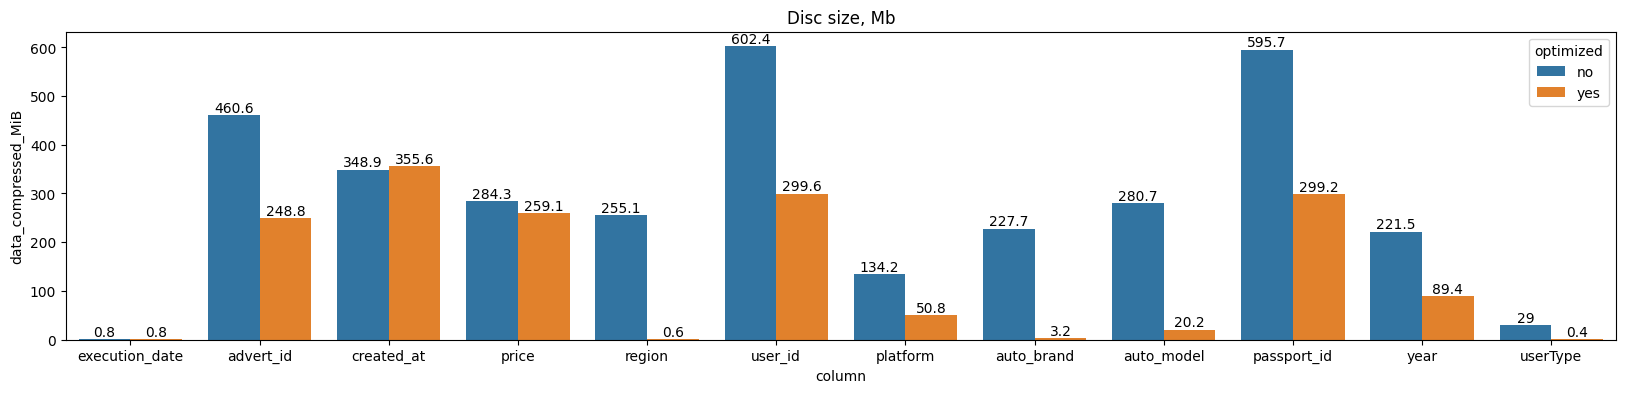

In [43]:
fig, ax = plt.subplots(figsize=(20, 4))
ax =sns.barplot(data=df, x = 'column', y = 'data_compressed_MiB', hue='optimized', ax=ax)
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Disc size, Mb');

In [44]:
fig = px.bar(df, x='column', y=['data_compressed_MiB'],  barmode='group', color = 'optimized',
              height=400,  hover_data=['type_codec', 'optimized'], text_auto=True, color_discrete_sequence =px.colors.qualitative.Pastel )
fig.update_layout(title=f"Disc size, Mb",
                  legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, title = "optimization"),
                  xaxis={'categoryorder':'sum descending', 'title': 'columns names'},
                  yaxis={'title': 'size (MiB)', 'visible': False}, template = "simple_white")
fig.update_traces(textfont_size=12, textangle=0,  cliponaxis=False)
fig.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



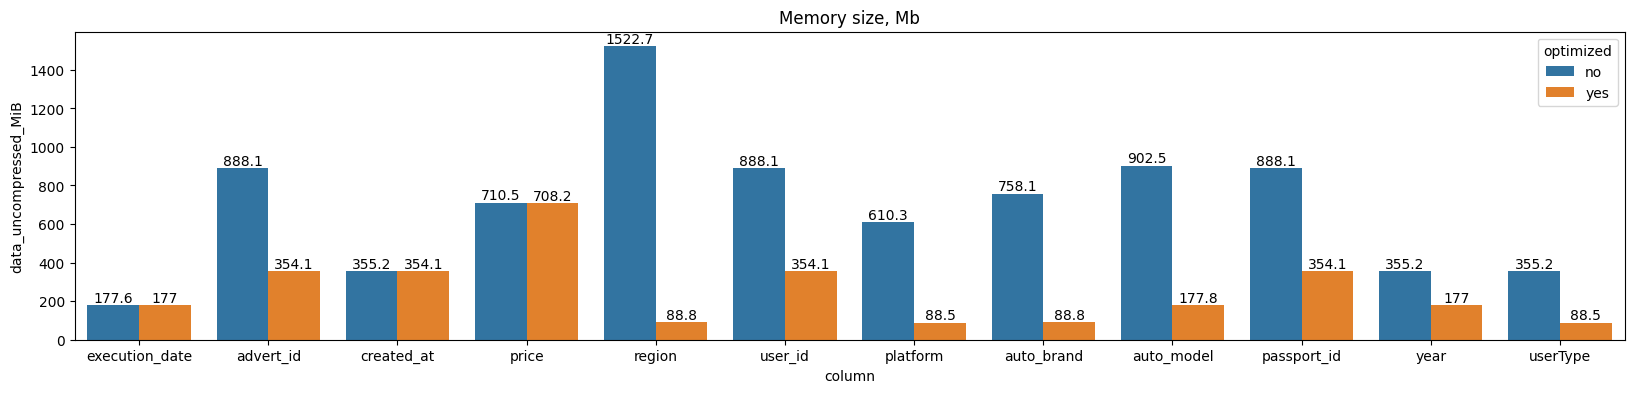

In [45]:
fig, ax = plt.subplots(figsize=(20, 4))
ax =sns.barplot(data=df, x = 'column', y = 'data_uncompressed_MiB', hue='optimized', ax=ax)
for i in ax.containers:
    ax.bar_label(i,)
ax.set_title('Memory size, Mb');

In [46]:
fig = px.bar(df, x='column', y=['data_uncompressed_MiB'],  barmode='group', color = 'optimized',
              height=400,  hover_data=['type_codec', 'optimized'], text_auto=True, color_discrete_sequence =px.colors.qualitative.Pastel )
fig.update_layout(title=f"Memory size, Mb",
                  legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, title = "optimization"),
                  xaxis={'categoryorder':'sum descending', 'title': 'columns names'},
                  yaxis={'title': 'size (MiB)', 'visible': False}, template = "simple_white")
fig.update_traces(textfont_size=12, textangle=0,  cliponaxis=False)
fig.show()

## Спасибо, что дочитали :))